## Predicting errors in basketball free-throw shots

Hyperparameter search for free-throw prediction

List of pkl files with each experiment:

* `prediction_nn1_lr`: for Adam optimizer, 3 layers $(100,100,10)$ ReLU activation, learning rate $\in [0.0001, 0.001, 0.01]$ 
    - Learning curves with learning rates of 0.001 and 0.01 are very noisy, possibly because of constant jumps around the error landscape. For further analysis, we use $lr=0.0001=1e-4$
    - Training error plateaus out at 20 mm, while best test error is at ~30 mm (2x worse than a simple linear regression)
    
* **TODO** Run an experiment with `n_hidden=3` but with more nodes and dropout in the middle layers (0.3 for now)

* **TODO** Replicate linear regression fits the way Rishi and Maurice did for the other dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import pdb

import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from scipy import io

from sklearn.model_selection import cross_val_score

import random
import torch
def set_seed(seed=None, seed_torch=True):
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
SEED = 2021
set_seed(seed=SEED)

Random seed 2021 has been set.


In [25]:
mat = io.loadmat('data_for_tanvi.mat');
importance = io.loadmat('tanvi_data_ix_iz.mat');
old_lab_idx=0;
nfeatures = [20,100,500,1000,1500,1820];
nepoch = 5;
df_all = pd.DataFrame()

In [4]:
''' Make data loader
'''
def make_data_loader(X_train, X_test, y_train, y_test,batch_size=64,SEED=2021):
    g_seed = torch.Generator()
    g_seed.manual_seed(SEED)

    test_data = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_data, batch_size=batch_size,
                         shuffle=False, num_workers=2,
                         worker_init_fn=seed_worker,
                         generator=g_seed)

    train_data = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_data, batch_size=batch_size, drop_last=True,
                        shuffle=True, num_workers=2,
                         worker_init_fn=seed_worker,
                         generator=g_seed)
    return train_loader, test_loader

In [3]:
''' Define MLP class
'''
class Net(nn.Module):
    def __init__(self, actv, input_feature_num, hidden_unit_nums, output_feature_num):
        super(Net,self).__init__()
        self.input_feature_num = input_feature_num;
        self.hidden_unit_nums = hidden_unit_nums;
        self.output_feature_num = output_feature_num;
        
        self.mlp = nn.Sequential();
        
        curr_in_num = input_feature_num;
        for i in range(len(hidden_unit_nums)):
            curr_out_num = hidden_unit_nums[i];
            layer = nn.Linear(curr_in_num, curr_out_num);
            curr_in_num = curr_out_num
            
            self.mlp.add_module(f'Linear_{i}', layer)
            
            actv_layer = eval('nn.%s'%actv);
#             print('added activation')
            self.mlp.add_module(f'Activation_{i}', actv_layer)
            
        out_layer = nn.Linear(curr_in_num, output_feature_num);
        self.mlp.add_module('Output', out_layer)
    
    def forward(self, x):
        return self.mlp(x)

In [104]:
''' Train on train_loader
'''

def train_loop(net, train_loader, X_train, X_test,criterion, 
               nepoch=10, lr=1e-3):
# net = Net('ReLU()',X_train.shape[1],[100,100,10],1).to('cpu'); #tip: X_train.shape[1] or X_train.size(0)

# criterion = nn.MSELoss();
    optimizer = optim.Adam(net.parameters(),lr=lr);

    yy_pred, yy_pred_test = np.zeros((len(X_train),nepoch)), np.zeros((len(X_test),nepoch))

    net.train();
    for i_epoch in tqdm(range(nepoch),position=0,leave=True):

        for dat in train_loader:
            inputs, labels = dat;
            inputs = inputs.float();
            y_true = labels.float();

            optimizer.zero_grad();
            y_pred = net.forward(inputs).squeeze();
            loss = criterion(y_pred, y_true);

            loss.backward();
            optimizer.step();


        net.eval();
        yy_pred[:,i_epoch] = net.forward(X_train.float()).squeeze().detach().numpy()
        yy_pred_test[:,i_epoch] = net.forward(X_test.float()).squeeze().detach().numpy()
        
    return yy_pred, yy_pred_test


In [115]:
nepoch=100

var_names = ['DX','DZ']

lr_list = [1e-4, 0.001, 0.01]

mul_factor = 1000;

In [116]:
row = [];
for ifeat in nfeatures:
    print(f'Features: {ifeat}')
    old_lab = pd.DataFrame()
    for var in var_names:
        dx = mat[var][0][old_lab_idx]
        old_lab[var] = dx.ravel()*mul_factor;

    plist = importance['ix'][0][:ifeat]#nfeat; #mat['P'][0][old_lab_idx].shape[1]
    
    # make train dataframe
    for ifeature in plist:
        dx = mat['P'][0][old_lab_idx][:,ifeature];
        old_lab[f'P_{ifeature}'] = dx.ravel()
    old_lab.tail(10)
    
    old_lab.dropna(inplace=True);
    old_lab = old_lab[old_lab['DX']>0]; #print(old_lab.shape)
    
    # make test dataframe
    new_lab=pd.DataFrame()
    for i in range(1,len(mat['DX'][0])-1):
        df = pd.DataFrame();

        for var in var_names:
            dx = mat[var][0][i]
            df[var] = dx.ravel()*mul_factor;
        for ifeature in plist:
            dx = mat['P'][0][i][:,ifeature];
            df[f'P_{ifeature}'] = dx.ravel()

        df['dataset_id'] = i;

        new_lab = pd.concat((new_lab,df),ignore_index=True)

    new_lab.dropna(inplace=True);
    new_lab = new_lab[new_lab['DX']>0];
    
    # make train and test iterables
    X_train = torch.tensor(old_lab.drop(['DX','DZ'],axis=1).to_numpy())
    y_train = torch.tensor(old_lab['DX'].to_numpy())

    X_test = torch.tensor(new_lab.drop(['DX','DZ','dataset_id'],axis=1).to_numpy())
    y_test = torch.tensor(new_lab['DX'].to_numpy())
    
    train_loader, test_loader = make_data_loader(X_train, X_test, y_train, y_test)
    
    for lr in lr_list:
        
        net = Net('ReLU()',X_train.shape[1],[100,100,10],1).to('cpu'); #tip: X_train.shape[1] or X_train.size(0)
        criterion = nn.MSELoss()
        
        train_pred, test_pred = train_loop(net, train_loader, X_train, X_test, criterion, 
                                       nepoch,lr=lr)
    
        train_err = [np.sqrt(criterion(y_train,torch.tensor(train_pred[:,epoch])).clone().detach().numpy()) for epoch in range(nepoch)]
        test_err = [np.sqrt(criterion(y_test,torch.tensor(test_pred[:,epoch])).clone().detach().numpy()) for epoch in range(nepoch)]
    
        row.append(pd.Series({'nfeatures':ifeat, 'train_err':train_err, 'test_err':test_err, 
           'non-linearity':'ReLU', 'learning_rate':lr,'mul_factor':mul_factor,
                              'optim':optim_type})); #print(row)
#     pd.concat([df_all, row],axis=0,ignore_index=True);
    
    

Features: 20


100%|██████████| 100/100 [03:04<00:00,  1.68s/it]


Features: 100


100%|██████████| 100/100 [03:32<00:00,  1.77s/it]


Features: 500


100%|██████████| 100/100 [03:27<00:00,  2.00s/it]


Features: 1000


100%|██████████| 100/100 [03:18<00:00,  2.02s/it]


Features: 1500


100%|██████████| 100/100 [03:46<00:00,  2.00s/it]


Features: 1820


100%|██████████| 100/100 [04:06<00:00,  2.12s/it]


In [124]:
row = pd.DataFrame(row)

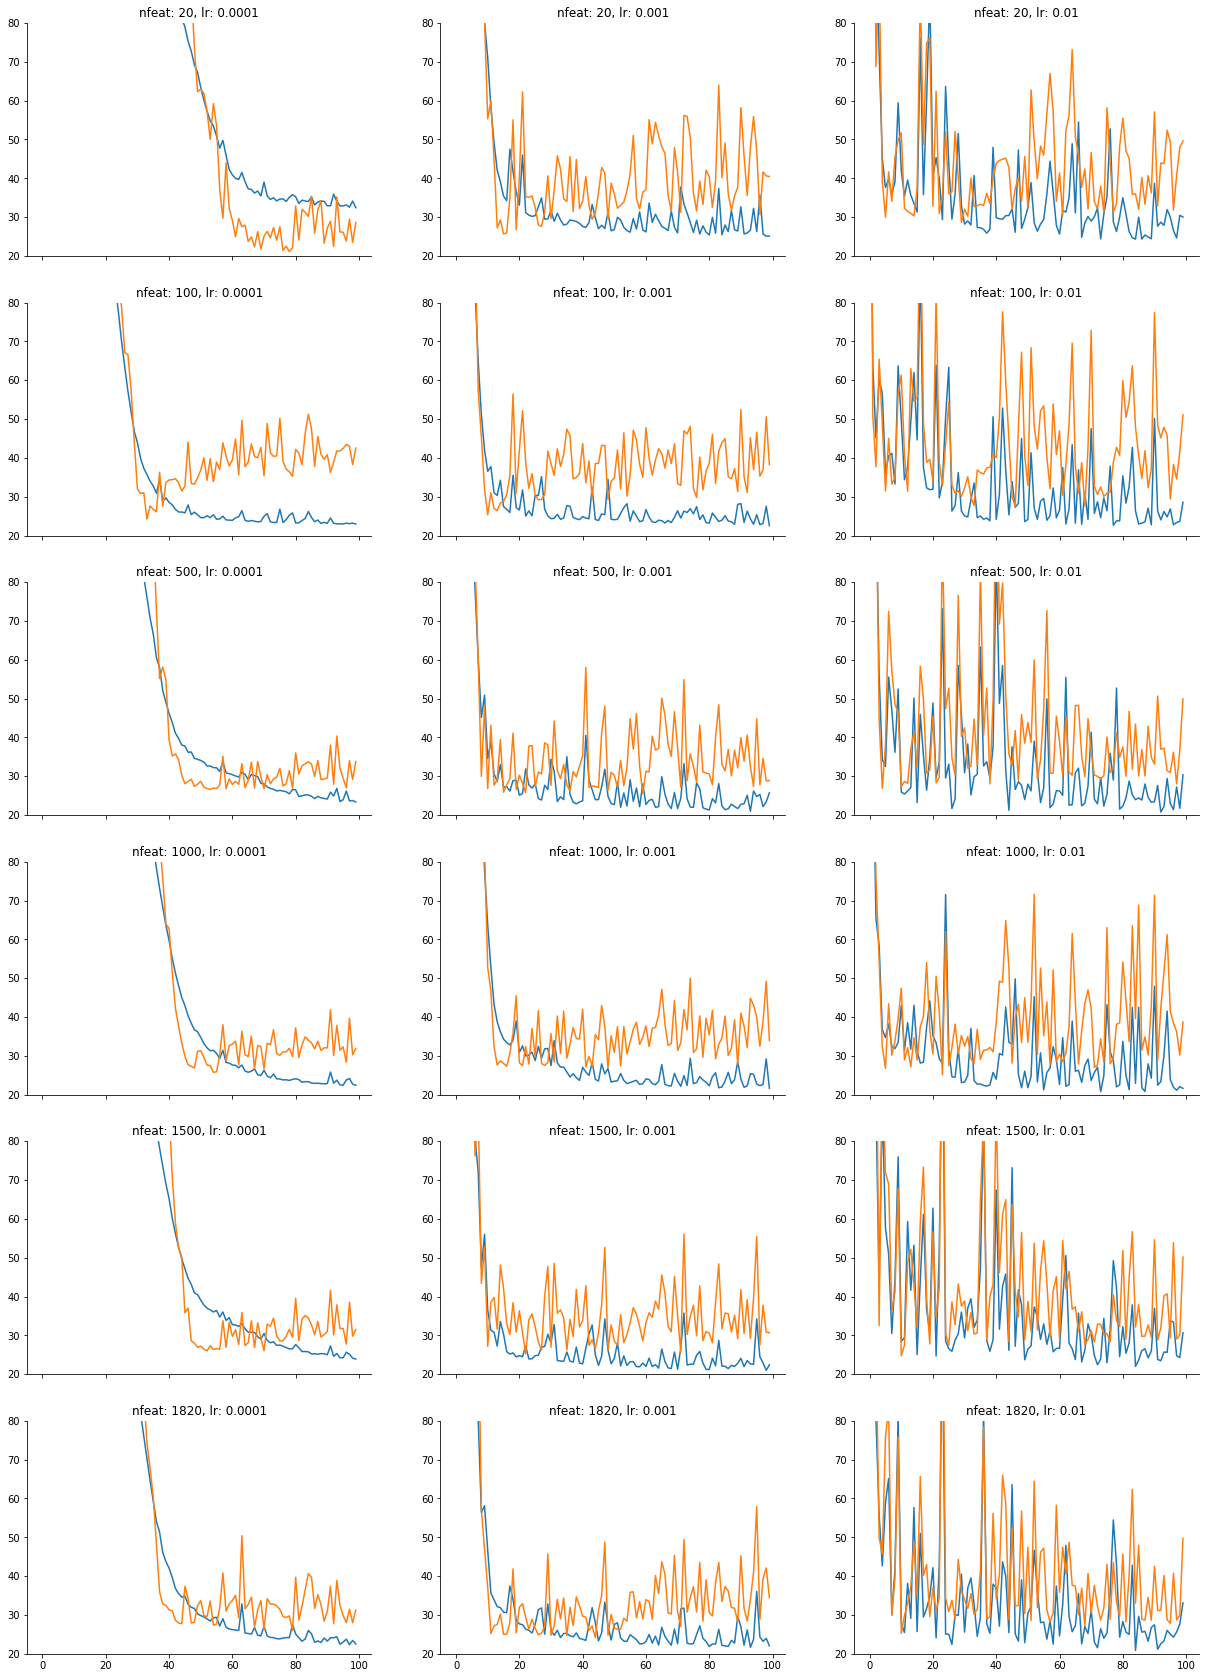

In [122]:
start_idx=0;
f,ax=plt.subplots(6,3,figsize=(21,30),sharex=True,sharey='col'); ax=ax.flatten()
for idf in range(len(row)):
    ax[idf].plot(row.iloc[idf]['train_err'][start_idx:]);
    ax[idf].plot(row.iloc[idf]['test_err'][start_idx:]);
    nfeat = row.iloc[idf]['nfeatures']; lr = row.iloc[idf]['learning_rate']
    ax[idf].set_title(f'nfeat: {nfeat}, lr: {lr}');
    ax[idf].set_ylim([20,80])
    
sns.despine()

In [136]:
row.to_pickle('./prediction_nn1_lr.pkl')

In [138]:
optim_type='SGD'
eval(['optim.',optim_type])

TypeError: eval() arg 1 must be a string, bytes or code object

In [150]:
l=['optim.',optim_type,]
l=''.join(l);
eval(l)

torch.optim.sgd.SGD